# Pipeline for High-z Radio Galaxies 16: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=14)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Get estimators list

In [13]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [23]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 85548 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies.


---

## Possible correlations

In [24]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [25]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [26]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [27]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

## Split data: Test, Train, Validation

In [28]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (85548, 39)
Data for Modeling (Train and Test): (68438, 39)
Unseen Data For Validation: (17110, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [29]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [30]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [31]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [32]:
rsd_vals

z_y         223.403109
i_z         212.574861
class       134.705305
r_i         113.463640
g_r          96.825118
g_i          74.616533
J_H          41.189887
H_K          32.683487
w2_w3        32.351901
band_num     21.866931
w3_w4        17.318863
gmag          7.042267
rmag          6.571728
g/J           6.331725
ymag          6.115928
imag          6.013591
zmag          5.983064
r/H           5.765161
W1mproPM      5.628715
i/K           5.588449
w1/w4         5.327220
W2mproPM      4.904682
w1/w3         4.780516
y/W2          4.617528
z/W1          4.596861
w2/w4         4.529677
r/z           3.309207
i/y           2.876397
W3mag         2.723632
NUVmag        2.071626
Hmag          2.035694
Jmag          1.959401
FUV/K         1.443793
W4mag         1.339142
Kmag          1.243503
J/K           1.021266
FUVmag        0.742488
FUV_NUV     -38.853569
w1_w2      -241.352676
dtype: float64

In [33]:
correlation = norm_train_test_df.corr()

In [34]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [35]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [36]:
target_feat = 'class'

In [37]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [38]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [39]:
list_drop_corr

['i/K',
 'w1/w4',
 'g/J',
 'Jmag',
 'w2/w4',
 'r/H',
 'FUV_NUV',
 'W3mag',
 'zmag',
 'W2mproPM',
 'Kmag',
 'imag',
 'J/K',
 'w1/w3',
 'Hmag',
 'rmag',
 'W1mproPM',
 'g_i']

In [40]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [41]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [42]:
corr_discard = norm_train_test_discard.corr()

In [43]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
class     w1_w2       0.782290
band_num  ymag        0.738434
r/z       r_i         0.689108
NUVmag    FUVmag      0.686532
band_num  gmag        0.668914
y/W2      z/W1        0.651354
gmag      ymag        0.630444
ymag      y/W2        0.602216
          w2_w3       0.578916
H_K       ymag        0.573200
i/y       z_y         0.572537
          i_z         0.564492
r/z       i_z         0.523345
NUVmag    w3_w4       0.521784
dtype: float64

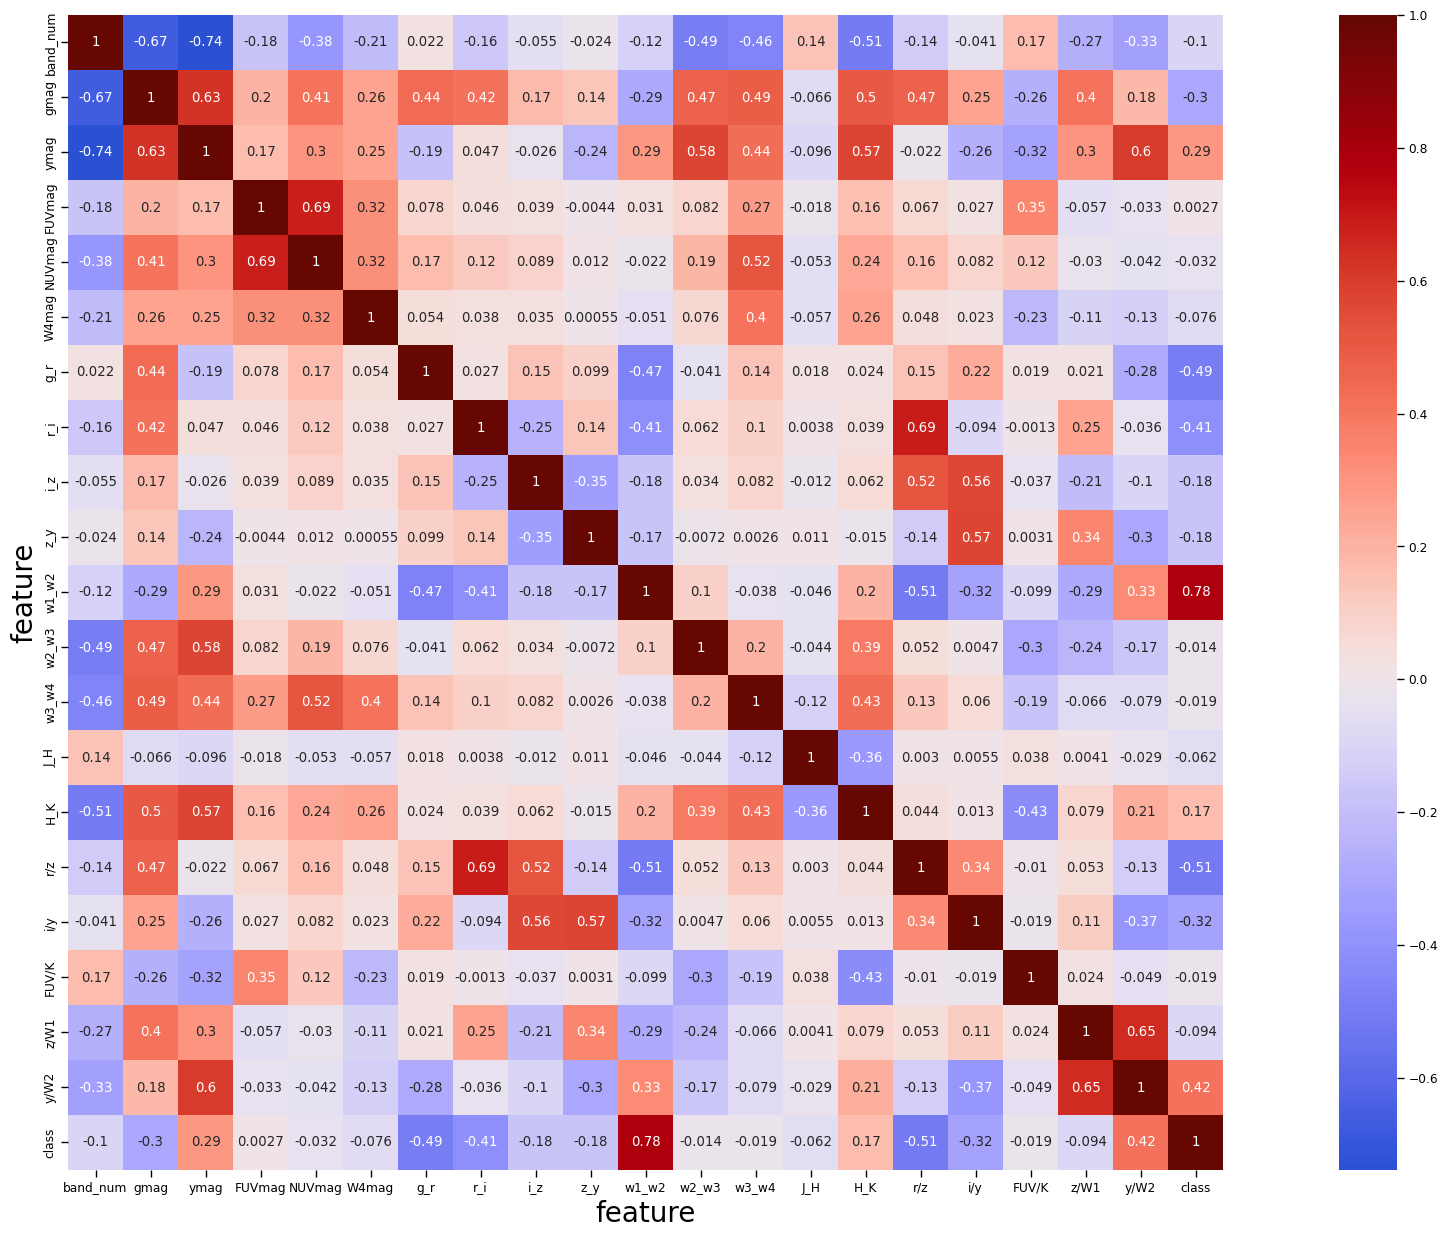

In [44]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [45]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [46]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [47]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y     
FUV/K     FUV/K     1.000000
w1_w2     class     0.714168
FUV/K     FUVmag    0.604958
g_r       class     0.552102
NUVmag    FUVmag    0.536125
r/z       class     0.516570
class     w1_w2     0.492046
r_i       class     0.453023
band_num  gmag      0.410168
          ymag      0.375535
J_H       H_K       0.360670
r_i       r/z       0.343060
r/z       r_i       0.307023
band_num  class     0.282483
y/W2      class     0.270876
ymag      H_K       0.253039
class     r/z       0.252503
          g_r       0.248385
i/y       class     0.247245
gmag      class     0.217317
dtype: float64

In [48]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [49]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [50]:
target_feat = 'class'

In [51]:
list_drop_pps = []

In [52]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [53]:
list_drop_pps

[]

In [54]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [55]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [56]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w1_w2,class,0.714168,classification,True,weighted F1,0.5544,0.872633,DecisionTreeClassifier()
1,g_r,class,0.552102,classification,True,weighted F1,0.5544,0.800417,DecisionTreeClassifier()
2,r/z,class,0.516570,classification,True,weighted F1,0.5544,0.784584,DecisionTreeClassifier()
3,r_i,class,0.453023,classification,True,weighted F1,0.5544,0.756267,DecisionTreeClassifier()
4,band_num,class,0.282483,classification,True,weighted F1,0.5544,0.680275,DecisionTreeClassifier()
5,y/W2,class,0.270876,classification,True,weighted F1,0.5544,0.675102,DecisionTreeClassifier()
6,i/y,class,0.247245,classification,True,weighted F1,0.5544,0.664572,DecisionTreeClassifier()
7,gmag,class,0.217317,classification,True,weighted F1,0.5544,0.651236,DecisionTreeClassifier()
8,i_z,class,0.176033,classification,True,weighted F1,0.5544,0.632840,DecisionTreeClassifier()
9,ymag,class,0.131645,classification,True,weighted F1,0.5544,0.613061,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [56]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [57]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [58]:
exp_AGN = pyc.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(68438, 39)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [59]:
pyc.get_config('X').columns

Index(['band_num', 'gmag', 'ymag', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i',
       'i_z', 'z_y', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y',
       'FUV/K', 'z/W1', 'y/W2'],
      dtype='object')

In [60]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
metric_to_optimize   = 'Recall'

In [61]:
final_selection_clf  = ['catboost', 'lightgbm', 'xgboost', 'rf', 'et', 'dummy']  # knn, qda do not have feature importances
n_models             = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, exclude=['knn'], sort='Recall')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9496,0.9837,0.9147,0.9417,0.9280,0.8892,0.8894,2.0710
lightgbm,Light Gradient Boosting Machine,0.9490,0.9836,0.9142,0.9405,0.9272,0.8879,0.8882,28.2000
xgboost,Extreme Gradient Boosting,0.9480,0.9825,0.9130,0.9390,0.9258,0.8858,0.8861,9.2410
rf,Random Forest Classifier,0.9490,0.9813,0.9106,0.9440,0.9270,0.8879,0.8882,0.7890
et,Extra Trees Classifier,0.9482,0.9807,0.9097,0.9425,0.9258,0.8860,0.8864,0.2580
dummy,Dummy Classifier,0.6447,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0160


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [62]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0], optimize=metric_to_optimize)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9526,0.9832,0.9243,0.9414,0.9327,0.8962,0.8963
1,0.9547,0.9849,0.9195,0.9514,0.9352,0.9004,0.9007
2,0.9495,0.9841,0.9130,0.9430,0.9278,0.8889,0.8892
3,0.9453,0.9806,0.9072,0.9369,0.9218,0.8798,0.8800
4,0.9443,0.9818,0.9036,0.9372,0.9201,0.8774,0.8777
5,0.9461,0.9821,0.9142,0.9329,0.9234,0.8819,0.8820
6,0.9526,0.9856,0.9213,0.9440,0.9325,0.8960,0.8962
7,0.9486,0.9839,0.9195,0.9349,0.9271,0.8875,0.8876
8,0.9562,0.9881,0.9277,0.9478,0.9376,0.9038,0.9040


In [63]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='random')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9505,0.9837,0.9201,0.9394,0.9297,0.8915,0.8917
1,0.9539,0.9845,0.9195,0.9491,0.9340,0.8986,0.8989
2,0.9512,0.9845,0.9177,0.9432,0.9303,0.8927,0.8929
3,0.9430,0.9803,0.9054,0.9322,0.9186,0.8748,0.8750
4,0.9436,0.9818,0.9066,0.9329,0.9195,0.8762,0.8764
5,0.9497,0.9814,0.9172,0.9398,0.9283,0.8896,0.8898
6,0.9528,0.9859,0.9248,0.9414,0.9330,0.8966,0.8967
7,0.9474,0.9843,0.9289,0.9235,0.9262,0.8853,0.8853
8,0.9555,0.9885,0.9254,0.9482,0.9367,0.9024,0.9026


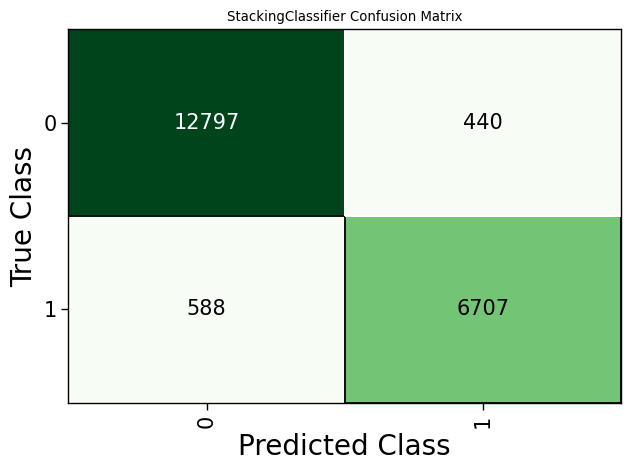

In [64]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

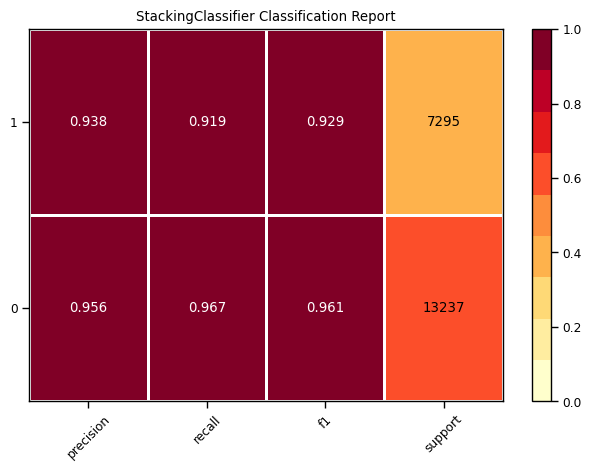

In [65]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

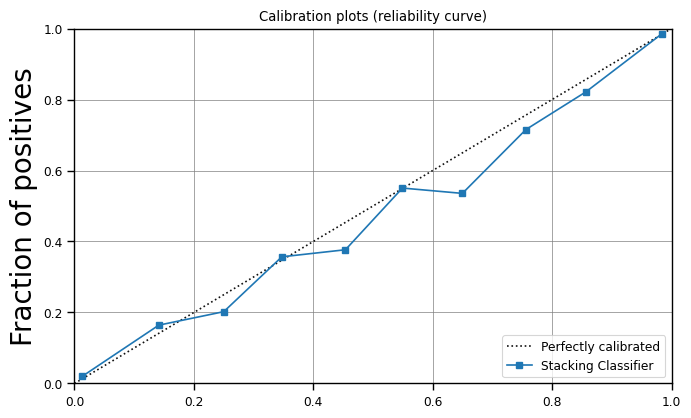

In [66]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

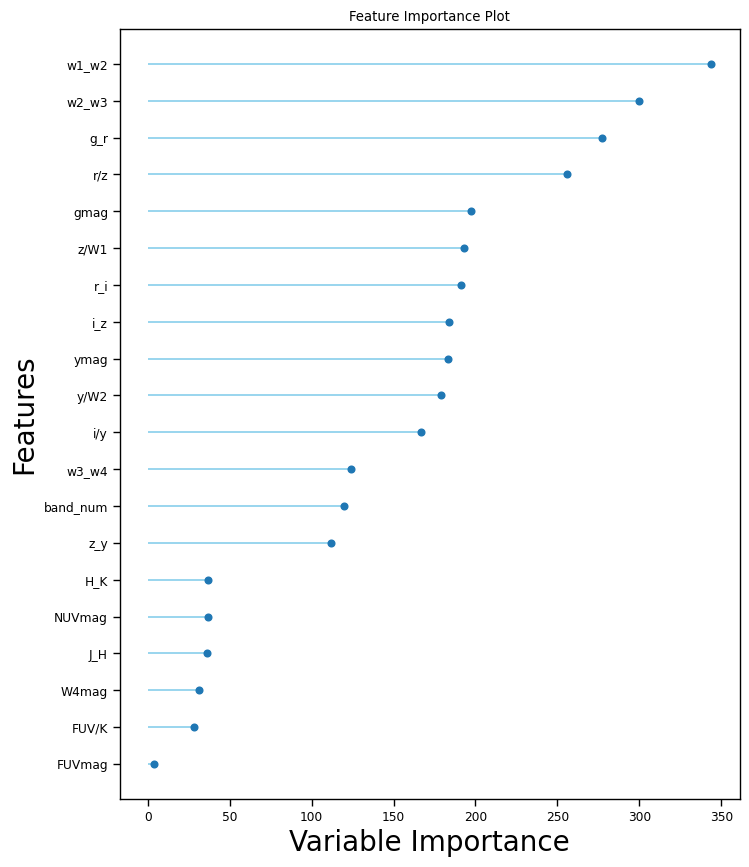

In [69]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [71]:
pyc.plot_model(tuned_AGN_clf.final_estimator, plot='parameter')

,Parameters
depth,4
l2_leaf_reg,5
border_count,254
thread_count,12
verbose,False
random_strength,0.2
task_type,CPU
n_estimators,250
random_state,42
eta,0.005


In [72]:
plt.rcParams.update(plt.rcParamsDefault)

In [73]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9499,0.9847,0.9194,0.9384,0.9288,0.8902,0.8903


,band_num,gmag,ymag,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,...,H_K,r/z,i/y,FUV/K,z/W1,y/W2,class,Label,Score_0,Score_1
0,0.330891,-0.113242,0.589152,0.157379,0.355869,0.202725,-0.864058,0.035725,-0.342749,0.164152,...,0.340844,-0.266919,-0.180432,-0.066972,0.234518,0.356623,1,1,0.0630,0.9370
1,0.757557,-1.677293,-0.898863,0.157379,-2.884640,-4.874414,-0.711718,-1.016473,-0.439741,-0.634078,...,0.340844,-1.248306,-0.976622,-0.066972,-0.522038,0.991584,1,1,0.0506,0.9494
2,-1.272924,1.382771,-0.641896,0.157379,0.355869,0.202725,2.797009,-6.370238,1.094413,5.737082,...,0.340844,-3.961715,6.134332,-0.066972,2.532855,-1.339728,0,0,0.9468,0.0532
3,-0.489590,0.217749,1.588654,0.157379,0.355869,0.202725,-0.584452,-0.504485,-0.106048,-1.099199,...,0.340844,-0.562810,-1.039337,-0.066972,0.140404,1.612456,1,1,0.0578,0.9422
4,-0.085322,0.320472,-0.555814,0.157379,0.355869,0.202725,0.921009,0.442293,0.570698,-0.019047,...,0.340844,0.869423,0.527794,-0.066972,0.525618,-0.016272,0,0,0.9474,0.0526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,-0.085322,-1.553072,-0.851244,0.157379,0.355869,0.202725,-0.909395,-1.305663,0.106532,-0.230889,...,0.340844,-1.033976,-0.057948,-0.066972,-1.608916,-0.761561,1,1,0.0523,0.9477
20528,1.192371,0.123455,-0.414501,0.157379,0.355869,0.202725,0.499505,0.298975,0.450346,0.031652,...,0.340844,0.633880,0.457203,-0.066972,0.337436,-0.065260,0,0,0.9422,0.0578
20529,0.330891,-0.638831,0.085842,0.157379,0.355869,0.202725,-0.579986,-0.389697,-0.398067,-0.198364,...,0.340844,-0.659760,-0.538709,-0.066972,-1.517640,-0.985219,0,1,0.4491,0.5509
20530,-0.085322,0.197329,-0.227169,0.157379,0.355869,0.202725,0.372862,0.075488,0.448544,0.244724,...,0.340844,0.405300,0.626414,-0.066972,-0.843572,-0.951424,0,0,0.9182,0.0818


In [74]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9499,0.9847,0.9194,0.9384,0.9288,0.8902,0.8903


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [75]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

In [76]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, 'models/classification_AGN_galaxy_may_15_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('../../models/config_classification_AGN_galaxy_may_15_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [57]:
if load_model_flag:
    if use_5sigma:
        final_AGN_clf = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [58]:
estimators_list = get_base_estimators_names(final_AGN_clf)

In [59]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_AGN = extended_cols_AGN.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [60]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [61]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    if hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)
else:
    if hasattr(final_AGN_clf.final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [62]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_clf.estimators
    estimators_list_ = final_AGN_clf.estimators_

In [63]:
base_models_names = [model[0] for model in estimators_list]

In [64]:
coef_sorted_base_df = {}

In [65]:
for model, model_fit in zip(base_models_names, estimators_list_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [66]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [67]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for lightgbm...
Calculating for xgboost...
Calculating for rf...
Calculating for et...


lightgbm              xgboost                   rf                   et  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w1_w2  10.800000     w1_w2  55.967968     w1_w2  28.783206     w1_w2   
1      w2_w3  10.266667       r/z  10.332925       r/z  13.748579      gmag   
2        g_r   9.300000      y/W2   5.842956       r_i  11.148273       g_r   
3        r/z   8.166667     w2_w3   4.290623       g_r  10.613189      ymag   
4       gmag   6.866667     w3_w4   2.953234      y/W2   6.622074       r/z   
5       ymag   6.433333       g_r   2.546161      gmag   5.085958      y/W2   
6       z/W1   6.433333      ymag   2.457378       i/y   4.476994       r_i   
7        r_i   6.300000      gmag   2.410675      ymag   3.210881  band_num   
8       y/W2   6.233333     W4mag   1.576698      z/W1   2.998381      z/W1   
9        i/y   5.566667  band_num   1.543132     w2_w3   2.904613       i/y   
10       i_z   5.300000      z/W1   1.508464       i_z   2.713932     w2_w3   
11     w3_w4   4.533333       r_i   1.475048  band_num   2.049536       i_z   
12  band_num   3.633333    NUVmag   1.364476       z_y   1.723387       z_y   
13       z_y   3.433333       i/y   1.089148       H_K   1.158558     w3_w4   
14    NUVmag   1.733333       i_z   1.042412     w3_w4   0.894215       H_K   
15       H_K   1.566667       H_K   0.831650       J_H   0.650241     W4mag   
16     W4mag   1.333333     FUV/K   0.777145    NUVmag   0.378724    NUVmag   
17     FUV/K   1.066667       z_y   0.773110     FUV/K   0.377080       J_H   
18       J_H   1.000000       J_H   0.630705     W4mag   0.358987     FUV/K   
19    FUVmag   0.033333    FUVmag   0.586099    FUVmag   0.103193    FUVmag   

               
   Importance  
0   33.494765  
1   10.407363  
2    7.486392  
3    7.184761  
4    6.642163  
5    5.605816  
6    4.950921  
7    4.176399  
8    3.768177  
9    3.499426  
10   3.303939  
11   2.318488  
12   1.966051  
13   1.279290  
14   0.913196  
15   0.909582  
16   0.847589  
17   0.554468  
18   0.374660  
19   0.316553

In [68]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,40.502616
1,rf,25.449676
2,xgboost,14.519286
3,lightgbm,14.316553
4,w2_w3,1.240071
5,w1_w2,1.072562
6,gmag,0.827760
7,band_num,0.392887
8,ymag,0.306575
9,z/W1,0.248538


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	10.829
w2_w3	10.260
g_r	9.298
r/z	8.169
gmag	6.866
ymag	6.431
z/W1	6.430
r_i	6.300
y/W2	6.233
i/y	5.564
i_z	5.297
w3_w4	4.531
band_num	3.632
z_y	3.431
NUVmag	1.732
H_K	1.566
W4mag	1.333
FUV/K	1.066
J_H	1.000
FUVmag	0.034


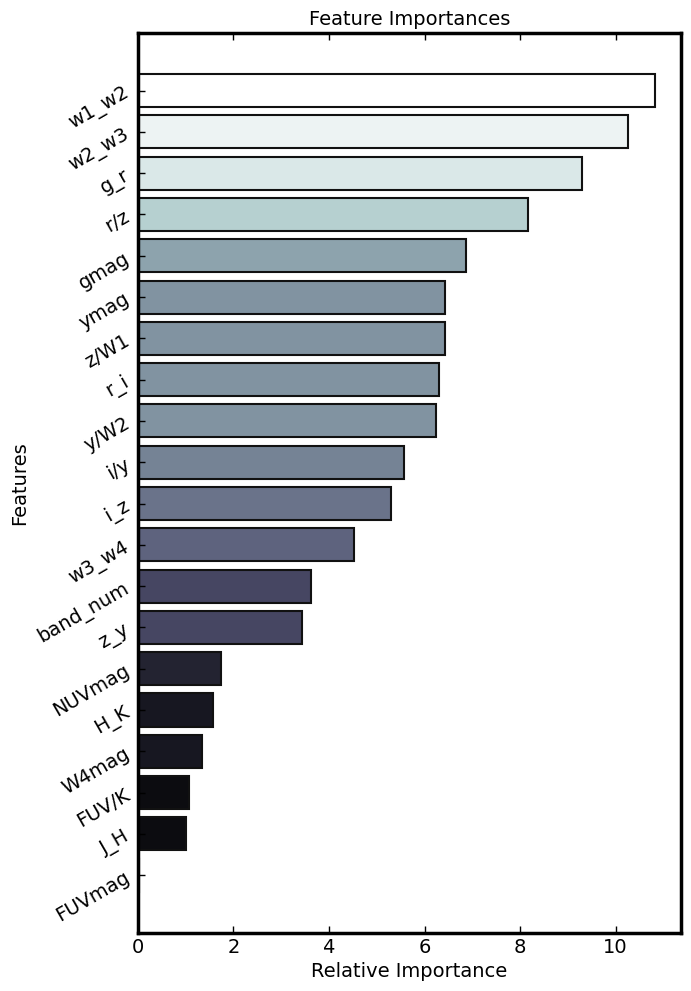

In [69]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [70]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

#### Calculate optimal threshold for classification

In [71]:
AGN_naive_threshold       = 0.5

In [72]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)

#### Calibration curve

In [73]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, 'class'],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, 'class'],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

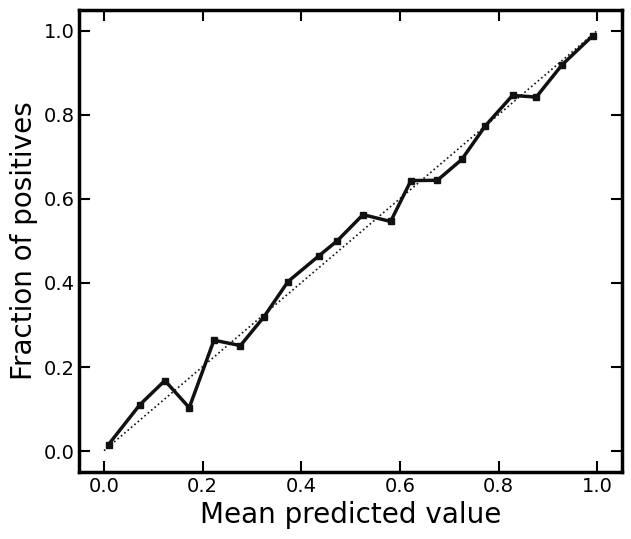

In [74]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

Calculate ROC AUC values and plots.

In [75]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, 'class'], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

In [76]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99897
Area under the curve (ROC) for test       = 0.99900
Area under the curve (ROC) for train+test = 0.99898
Area under the curve (ROC) for validation = 0.98426


In [77]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, 'class'], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

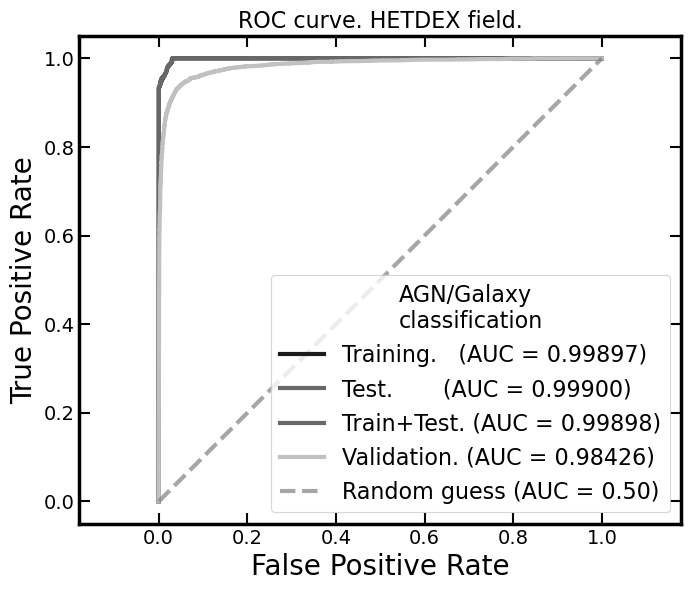

In [78]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Train+Test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [79]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [80]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training   = 0.30944
Optimal threshold from area under the curve (ROC) for test       = 0.31118
Optimal threshold from area under the curve (ROC) for train+test = 0.30944
Optimal threshold from area under the curve (ROC) for validation = 0.35312


##### Precision-Recall curve

In [81]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, 'class'],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, 'class'],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, 'class'],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, 'class'],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

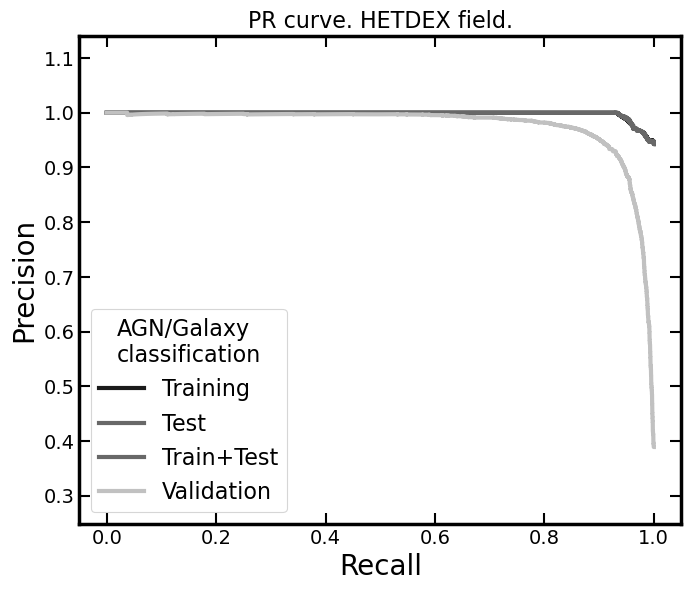

In [82]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Train+Test")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation")

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [83]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [84]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [85]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training   = 0.31196
Optimal threshold from Precision-Recall curve for test       = 0.31118
Optimal threshold from Precision-Recall curve for train+test = 0.31117
Optimal threshold from Precision-Recall curve for validation = 0.44093


---

In [86]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.5

In [87]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)

Create confusion matrix with validation data.

In [88]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [90]:
cm_mat_val_large = np.array([[np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 0)   & np.array(validation_prediction_clf.loc[:, 'Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 0)   & np.array(validation_prediction_clf.loc[:, 'Label'] == 0.5)),\
                              np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 0)   & np.array(validation_prediction_clf.loc[:, 'Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 0.5) & np.array(validation_prediction_clf.loc[:, 'Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 0.5) & np.array(validation_prediction_clf.loc[:, 'Label'] == 0.5)),\
                              np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 0.5) & np.array(validation_prediction_clf.loc[:, 'Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 1)   & np.array(validation_prediction_clf.loc[:, 'Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 1)   & np.array(validation_prediction_clf.loc[:, 'Label'] == 0.5)),\
                              np.sum(np.array(validation_prediction_clf.loc[:, 'class'] == 1)   & np.array(validation_prediction_clf.loc[:, 'Label'] == 1))]])

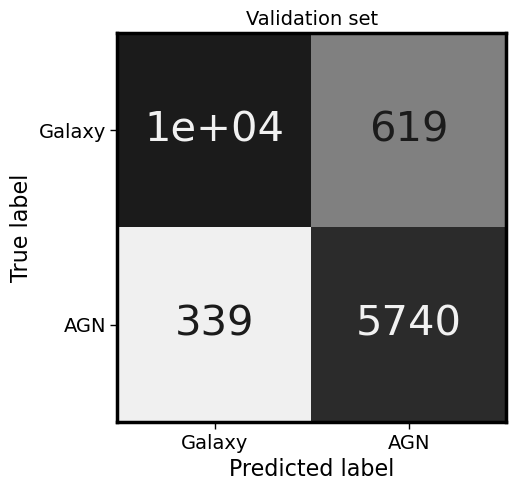

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

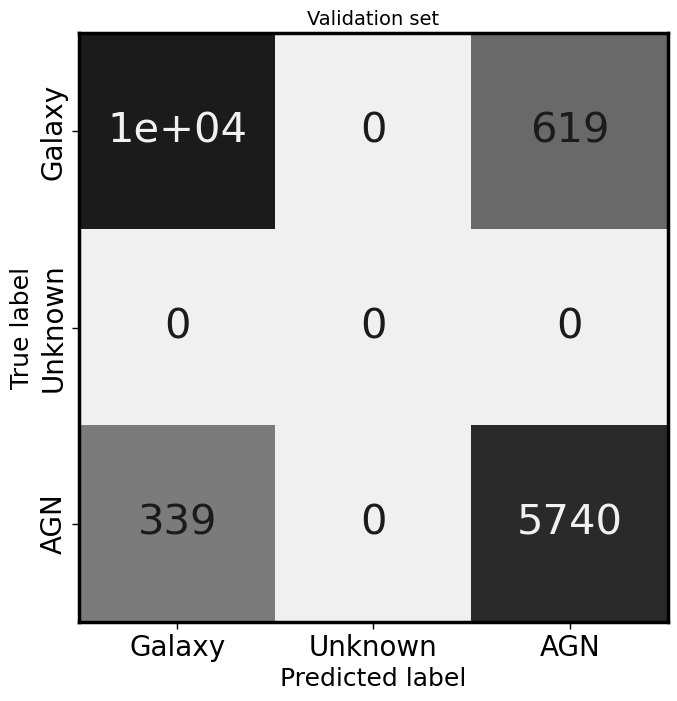

In [92]:
fig             = plt.figure(figsize=(8,7))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_val_large, title='Validation set', axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=True)

ax1.xaxis.get_label().set_fontsize(18)
ax1.yaxis.get_label().set_fontsize(18)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelrotation=90)
plt.yticks(va='center')

if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_validation_classification_AGN_galaxy_all_classes_04.pdf', bbox_inches='tight')
plt.show()

In [93]:
MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

In [94]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.8796
Accuracy is                         ACC = 0.9440
F1-score is                          F1 = 0.9230
Recall is                           TPR = 0.9442


In [95]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_pred_threshold, raw_score=True)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_pred_threshold, raw_score=True)

In [96]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                         [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [98]:
cm_mat_train_large = np.array([[np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 0)   & np.array(train_prediction_clf.loc[:, 'Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 0)   & np.array(train_prediction_clf.loc[:, 'Label'] == 0.5)),\
                                np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 0)   & np.array(train_prediction_clf.loc[:, 'Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 0.5) & np.array(train_prediction_clf.loc[:, 'Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 0.5) & np.array(train_prediction_clf.loc[:, 'Label'] == 0.5)),\
                                np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 0.5) & np.array(train_prediction_clf.loc[:, 'Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 1)   & np.array(train_prediction_clf.loc[:, 'Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 1)   & np.array(train_prediction_clf.loc[:, 'Label'] == 0.5)),\
                                np.sum(np.array(train_prediction_clf.loc[:, 'class'] == 1)   & np.array(train_prediction_clf.loc[:, 'Label'] == 1))]])

In [99]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                        [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [101]:
cm_mat_test_large = np.array([[np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 0)   & np.array(test_prediction_clf.loc[:, 'Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 0)   & np.array(test_prediction_clf.loc[:, 'Label'] == 0.5)),\
                               np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 0)   & np.array(test_prediction_clf.loc[:, 'Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 0.5) & np.array(test_prediction_clf.loc[:, 'Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 0.5) & np.array(test_prediction_clf.loc[:, 'Label'] == 0.5)),\
                               np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 0.5) & np.array(test_prediction_clf.loc[:, 'Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 1)   & np.array(test_prediction_clf.loc[:, 'Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 1)   & np.array(test_prediction_clf.loc[:, 'Label'] == 0.5)),\
                               np.sum(np.array(test_prediction_clf.loc[:, 'class'] == 1)   & np.array(test_prediction_clf.loc[:, 'Label'] == 1))]])

In [102]:
cm_mat_train_test = np.array([[np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [104]:
cm_mat_train_test_large = np.array([[np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 0)   & np.array(train_test_prediction_clf.loc[:, 'Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 0)   & np.array(train_test_prediction_clf.loc[:, 'Label'] == 0.5)),\
                                     np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 0)   & np.array(train_test_prediction_clf.loc[:, 'Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 0.5) & np.array(train_test_prediction_clf.loc[:, 'Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 0.5) & np.array(train_test_prediction_clf.loc[:, 'Label'] == 0.5)),\
                                     np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 0.5) & np.array(train_test_prediction_clf.loc[:, 'Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 1)   & np.array(train_test_prediction_clf.loc[:, 'Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 1)   & np.array(train_test_prediction_clf.loc[:, 'Label'] == 0.5)),\
                                     np.sum(np.array(train_test_prediction_clf.loc[:, 'class'] == 1)   & np.array(train_test_prediction_clf.loc[:, 'Label'] == 1))]])

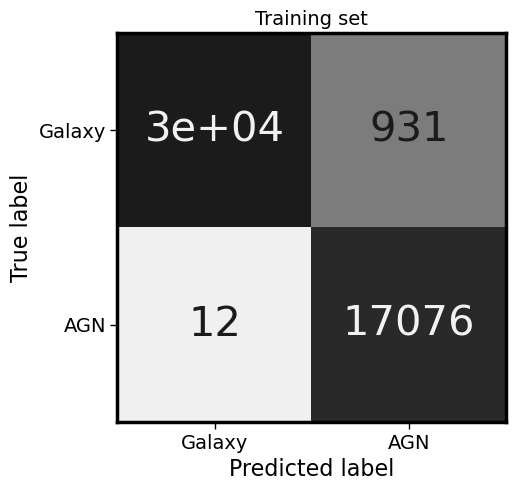

In [105]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

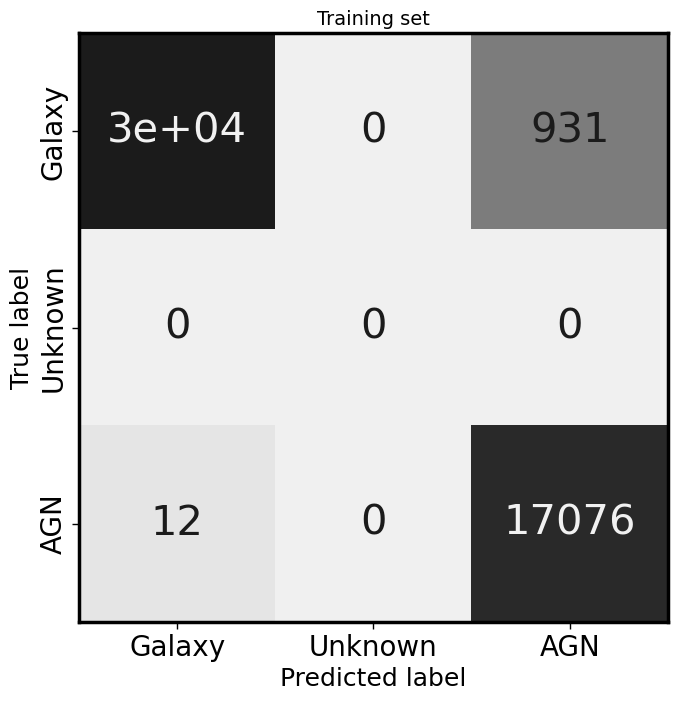

In [106]:
fig             = plt.figure(figsize=(8,7))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train_large, title='Training set', axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=True)

ax1.xaxis.get_label().set_fontsize(18)
ax1.yaxis.get_label().set_fontsize(18)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelrotation=90)
plt.yticks(va='center')

if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_train_classification_AGN_galaxy_all_classes_04.pdf', bbox_inches='tight')
plt.show()

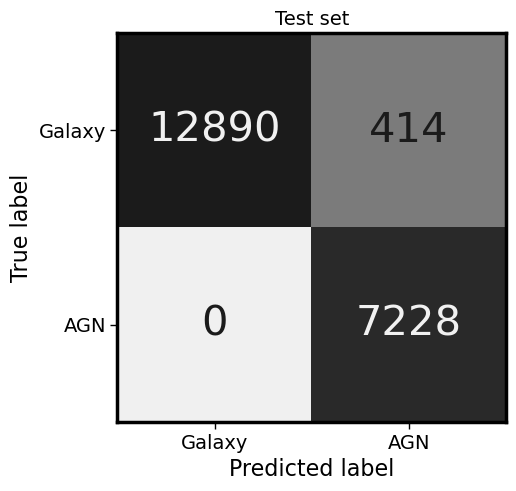

In [107]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

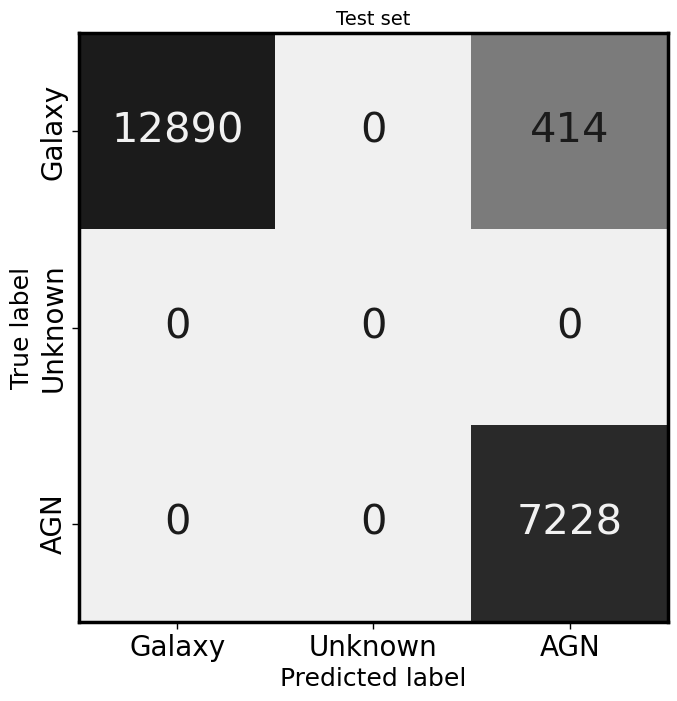

In [108]:
fig             = plt.figure(figsize=(8,7))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test_large, title='Test set', axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=True)

ax1.xaxis.get_label().set_fontsize(18)
ax1.yaxis.get_label().set_fontsize(18)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelrotation=90)
plt.yticks(va='center')

if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_test_classification_AGN_galaxy_all_classes_04.pdf', bbox_inches='tight')
plt.show()

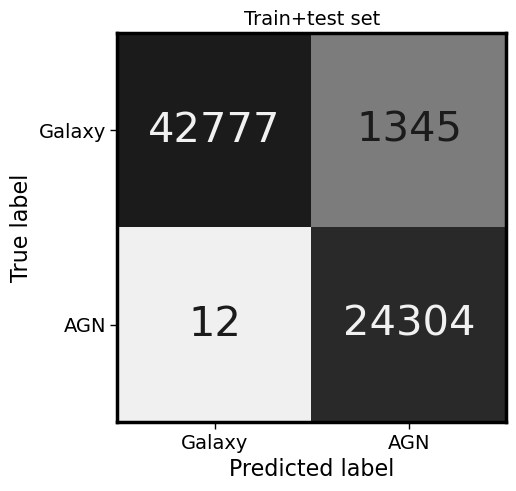

In [109]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

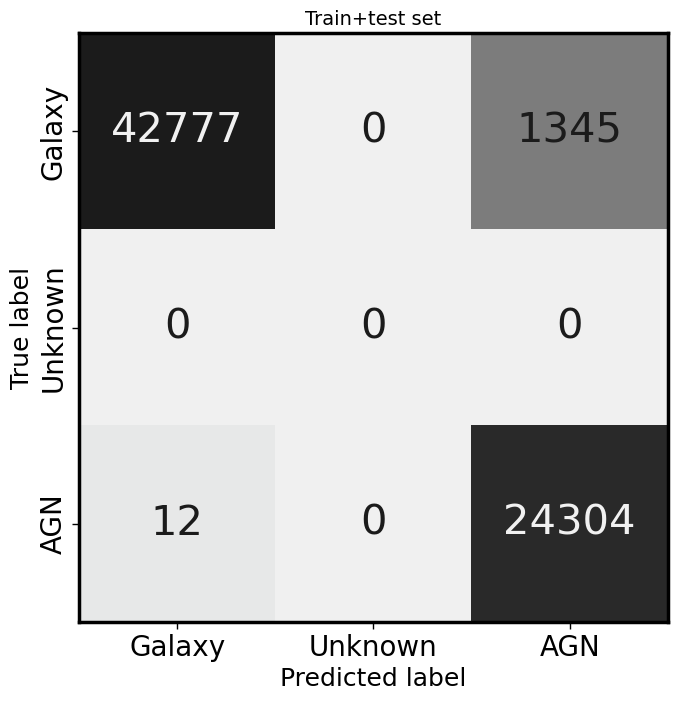

In [110]:
fig             = plt.figure(figsize=(8,7))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train_test_large, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=True)

ax1.xaxis.get_label().set_fontsize(18)
ax1.yaxis.get_label().set_fontsize(18)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelrotation=90)
plt.yticks(va='center')

if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_train_test_classification_AGN_galaxy_all_classes_04.pdf', bbox_inches='tight')
plt.show()

In [111]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

In [112]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9584
Accuracy is                         ACC = 0.9803
F1-score is                          F1 = 0.9731
Recall is                           TPR = 0.9993


In [113]:
MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

In [114]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9573
Accuracy is                         ACC = 0.9798
F1-score is                          F1 = 0.9722
Recall is                           TPR = 1.0000


In [115]:
MCC_radio_train_test    = MCC_from_CM(cm_mat_train_test)
ACC_radio_train_test    = ACC_from_CM(cm_mat_train_test)
F1_radio_train_test     = F1_from_CM(cm_mat_train_test)
Recall_radio_train_test = Recall_from_CM(cm_mat_train_test)

In [116]:
print('Metrics for Train+Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train_test:.4f}')

Metrics for Train+Test set.
Matthews Correlation Coefficient is MCC = 0.9581
Accuracy is                         ACC = 0.9802
F1-score is                          F1 = 0.9728
Recall is                           TPR = 0.9995
